# Time Series on monthly dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# load the data with DatetimeIndex
monthly_df = pd.read_csv('nitm18442004.csv', header=0, parse_dates=False)

# set the frequency of the DatetimeIndex
monthly_df.index = pd.date_range(start='1844-01', end='2004-12', freq='MS')
print(monthly_df)

               x
1844-01-01   4.5
1844-02-01   2.4
1844-03-01   4.8
1844-04-01   9.1
1844-05-01  10.9
...          ...
2004-08-01  15.4
2004-09-01  13.2
2004-10-01   8.6
2004-11-01   8.2
2004-12-01   6.2

[1932 rows x 1 columns]


## Preliminary Assessment

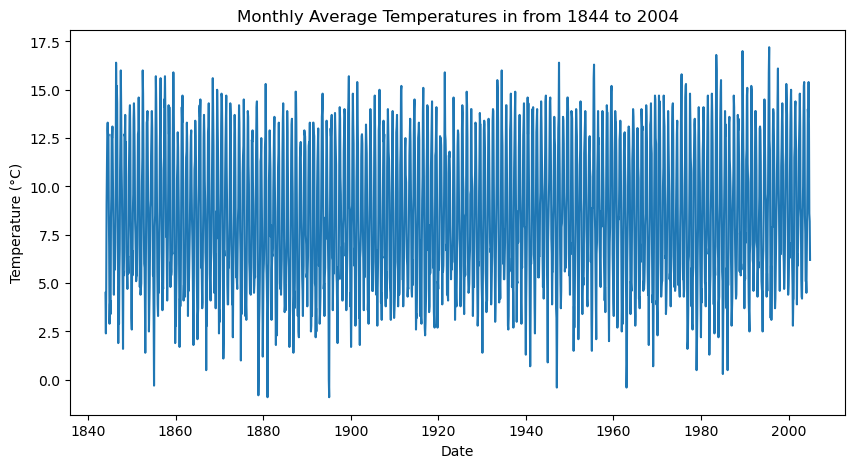

In [3]:
plt.figure(figsize=(10,5))
plt.plot(monthly_df)
plt.title('Monthly Average Temperatures in from 1844 to 2004')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.show()

In [4]:
#Check the stationary

In [5]:
# Determine rolling statistic
rolmean = monthly_df.rolling(window=12).mean()
rolestd = monthly_df.rolling(window=12).std()

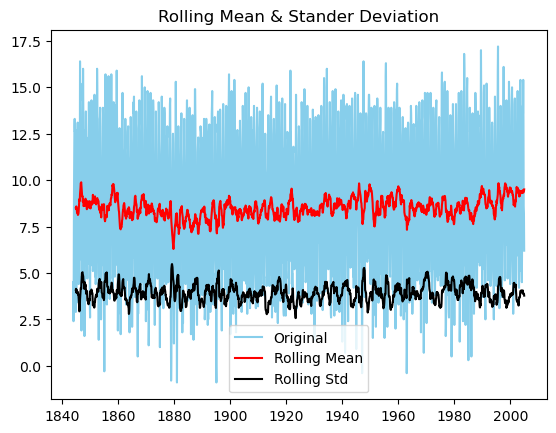

In [6]:
# Plot rolling statistic
orig = plt.plot(monthly_df, color = 'skyblue', label = 'Original')
mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
std = plt.plot(rolestd, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Stander Deviation')
plt.show(block=False)

From the plot, we can see that the series is stationary, with the rolling mean and standard deviation relatively constant over time.

In [7]:
#perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller

print("Result of Dickey-Fuller Test:")
dftest = adfuller(monthly_df['x'], autolag= 'aic')

dfoutput = pd.Series(dftest[0:4], index =['Test Statistic', 'P-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s) '%key] = value
    
print(dfoutput)

Result of Dickey-Fuller Test:
Test Statistic                   -5.000624
P-value                           0.000022
#Lags Used                       26.000000
Number of Observations Used    1905.000000
Critical Value (1%)              -3.433787
Critical Value (5%)              -2.863058
Critical Value (10%)             -2.567578
dtype: float64


The Dickey-Fuller test confirms this, with a very low p-value indicating that we can reject the null hypothesis of non-stationarity.

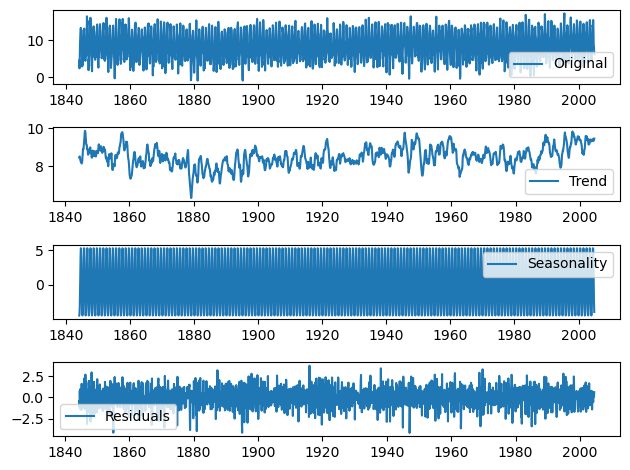

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(monthly_df)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(monthly_df, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

In [9]:
train = monthly_df.iloc[:len(monthly_df)-12]
test = monthly_df.iloc[len(monthly_df)-12:]

## Exponential Smoothing

#### Holt-Winters' Seasonal Exponential Smoothing

Holt-Winters' Seasonal Exponential Smoothing RMSE: 0.786
Holt-Winters' Seasonal Exponential Smoothing MAE: 0.695
Holt-Winters' Simple Exponential Smoothing R2: 0.953


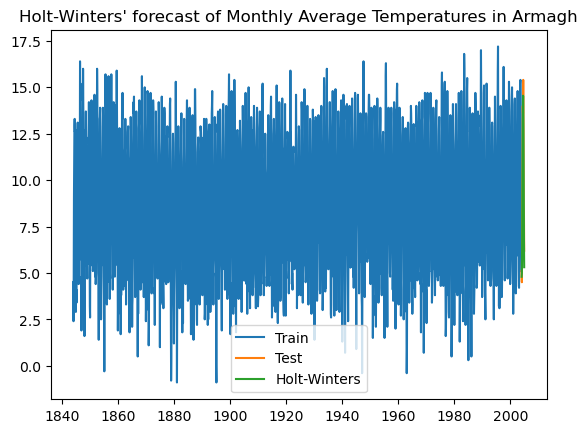

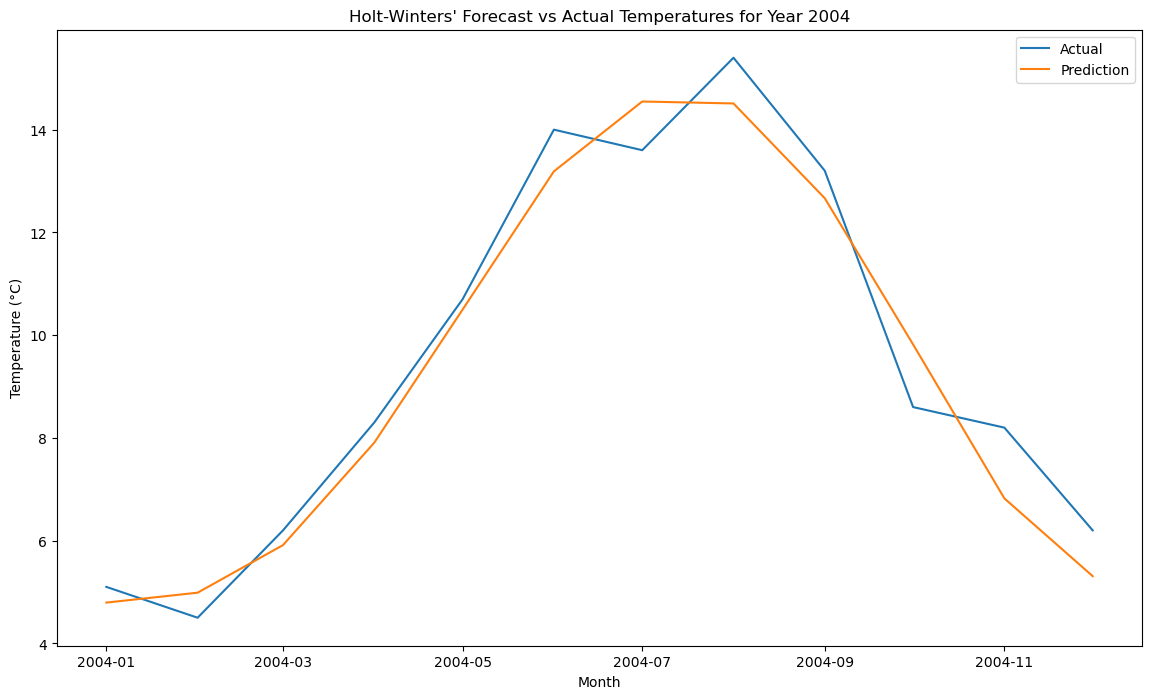

In [10]:
# Fit model
from math import sqrt
model = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='add').fit()

# Make predictions
predictions = model.forecast(12)

# Evaluate model
rmse = sqrt(mean_squared_error(test, predictions))
mae = mean_absolute_error(test, predictions)
r2 = r2_score(test, predictions)
print(f'Holt-Winters\' Seasonal Exponential Smoothing RMSE: {rmse:.3f}')
print(f'Holt-Winters\' Seasonal Exponential Smoothing MAE: {mae:.3f}')
print(f'Holt-Winters\' Simple Exponential Smoothing R2: {r2:.3f}')

plt.plot(train, label='Train',)
plt.plot(test, label='Test')
plt.plot(predictions, label='Holt-Winters')
plt.title('Holt-Winters\' forecast of Monthly Average Temperatures in Armagh')
plt.legend()
plt.show()

# Plot the actual values and forecast
plt.figure(figsize=(14,8))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, predictions, label='Prediction')
plt.title('Holt-Winters\' Forecast vs Actual Temperatures for Year 2004')
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

## SARIMA

C:\Users\Arnab Hati\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


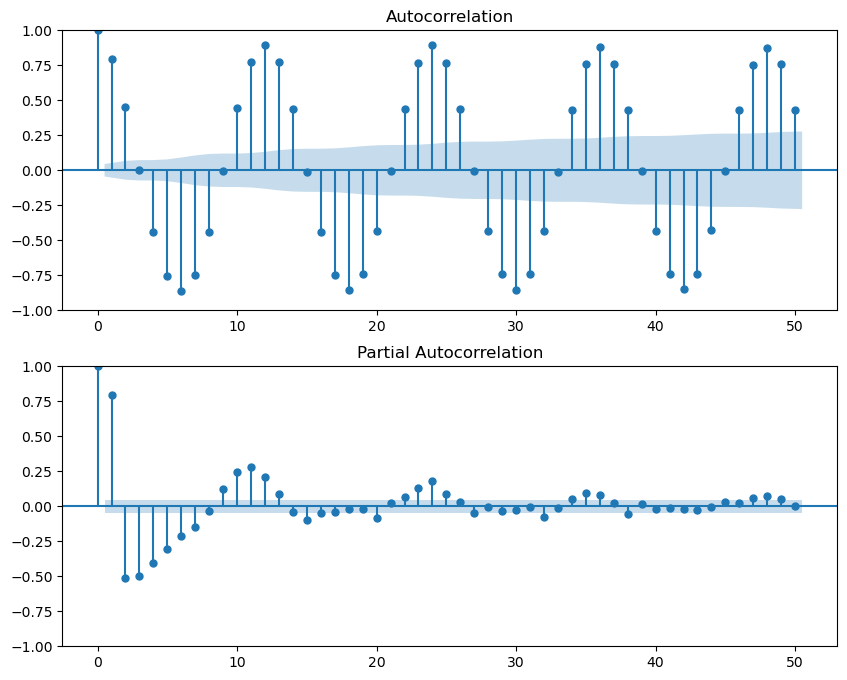

In [11]:
# Plot ACF and PACF of differenced series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(monthly_df, lags=50, ax=ax[0])
plot_pacf(monthly_df, lags=50, ax=ax[1])
plt.show()

In [12]:
## Split into Train and test
train = monthly_df.iloc[:len(monthly_df)-12]
test = monthly_df.iloc[len(monthly_df)-12:]

In [13]:
from pmdarima import auto_arima

# Fit the auto SARIMA model to the training data
model = auto_arima(train, seasonal=True, m=12)

# Make predictions
predictions = model.predict(start=test.index[0], end=test.index[-1])

# Print the model summary
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 1920
Model:             SARIMAX(3, 1, 1)x(2, 0, 1, 12)   Log Likelihood               -3197.157
Date:                            Thu, 11 May 2023   AIC                           6412.315
Time:                                    22:41:09   BIC                           6462.351
Sample:                                01-01-1844   HQIC                          6430.725
                                     - 12-01-2003                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5.453e-06   6.31e-05      0.086      0.931      -0.000       0.000
ar.L1          0.2692      0.024   

In [14]:
# Fit SARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX
train = monthly_df.iloc[:len(monthly_df)-12]
test = monthly_df.iloc[len(monthly_df)-12:]

model = SARIMAX(train, order=(3,1,1), seasonal_order=(1,0,1,12)).fit()

# Make predictions
predictions = model.predict(start=test.index[0], end=test.index[-1])

# Evaluate model
rmse = sqrt(mean_squared_error(test, predictions))
mae = mean_absolute_error(test, predictions)
r2 = r2_score(test, predictions)
print(f'SARIMA RMSE: {rmse:.3f}')
print(f'SARIMA MAE: {mae:.3f}')
print(f'SARIMA R2: {r2:.3f}')

C:\Users\Arnab Hati\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA RMSE: 0.847
SARIMA MAE: 0.755
SARIMA R2: 0.945


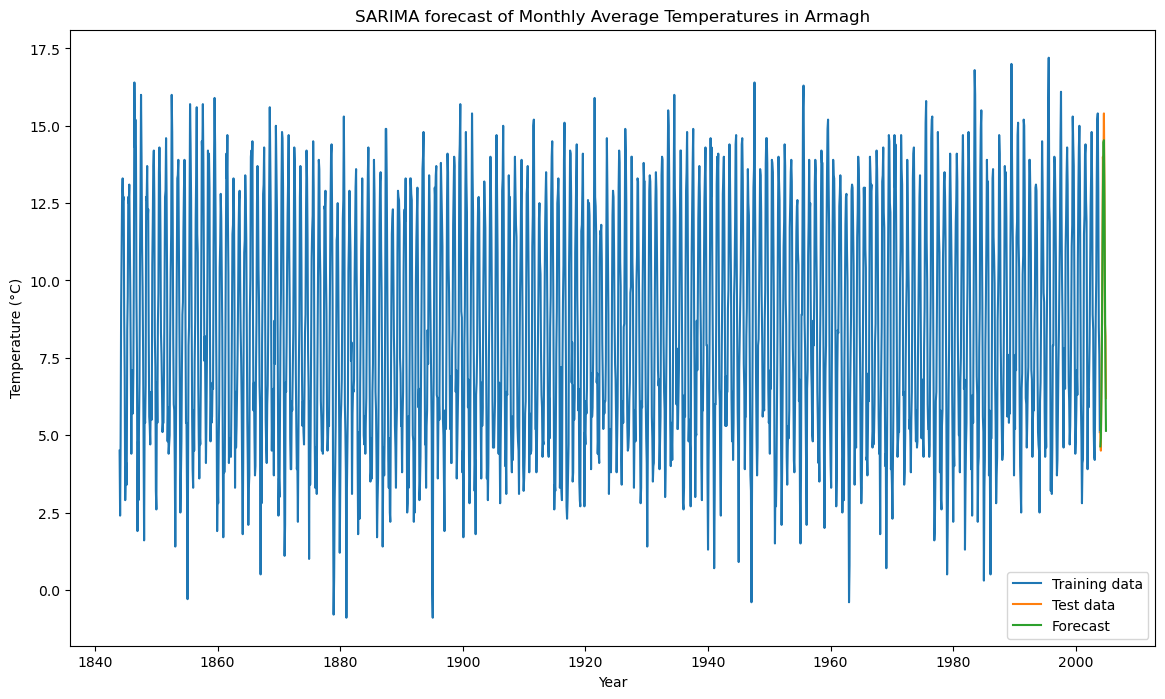

In [15]:
# Plot the actual and forecasted values
plt.figure(figsize=(14,8))
plt.plot(train.index, train, label='Training data')
plt.plot(test.index, test, label='Test data')
plt.plot(predictions.index, predictions, label='Forecast')
plt.legend()
plt.title('SARIMA forecast of Monthly Average Temperatures in Armagh')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.show()

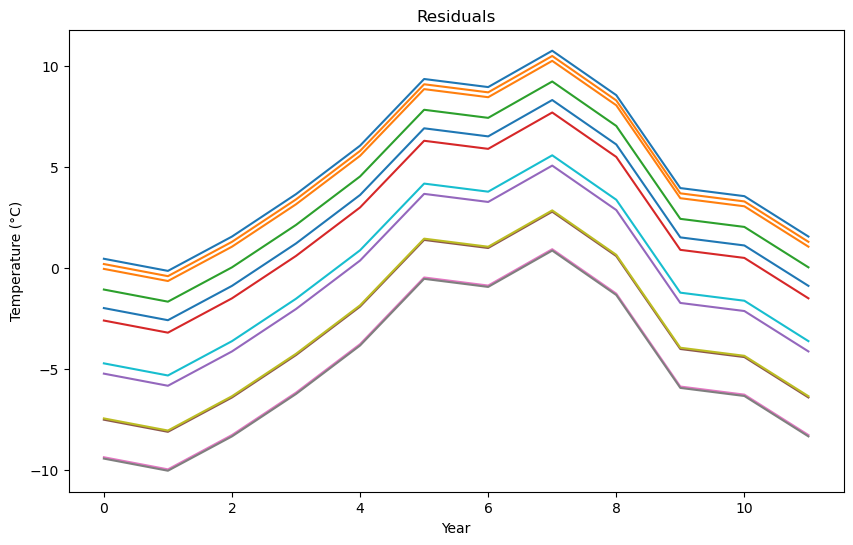

In [16]:
residuals = np.array(test) - np.array(predictions)
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.show()

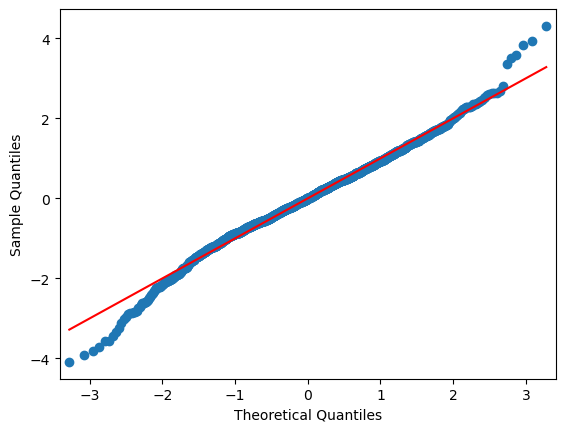

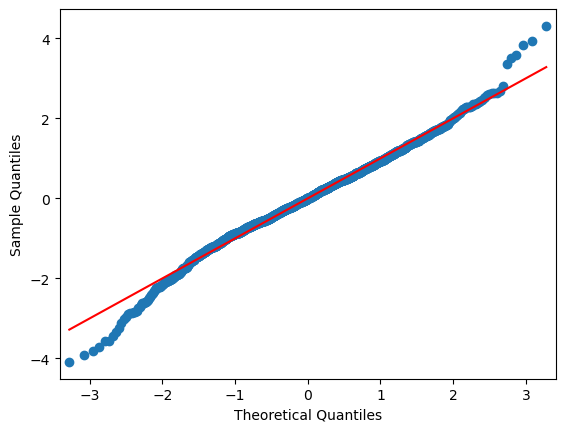

In [17]:
residuals = model.resid
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import norm

# Create a Q-Q plot of the residuals
qqplot(residuals, line='s',dist=norm, fit=True)

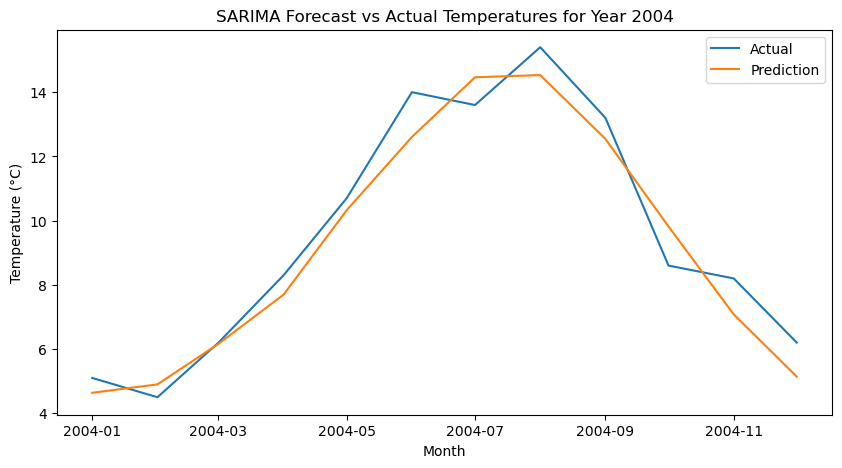

In [18]:
# Plot the actual values and forecast
plt.figure(figsize=(10,5))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, predictions, label='Prediction')
plt.title('SARIMA Forecast vs Actual Temperatures for Year 2004')
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

## Simple time series models

#### Seasonal Naive model

Seasonal Naive Model:
Seasonal Naive Model RMSE: 0.73
Seasonal Naive Model MAE: 0.58
Seasonal Naive Model R2 Score: 0.96


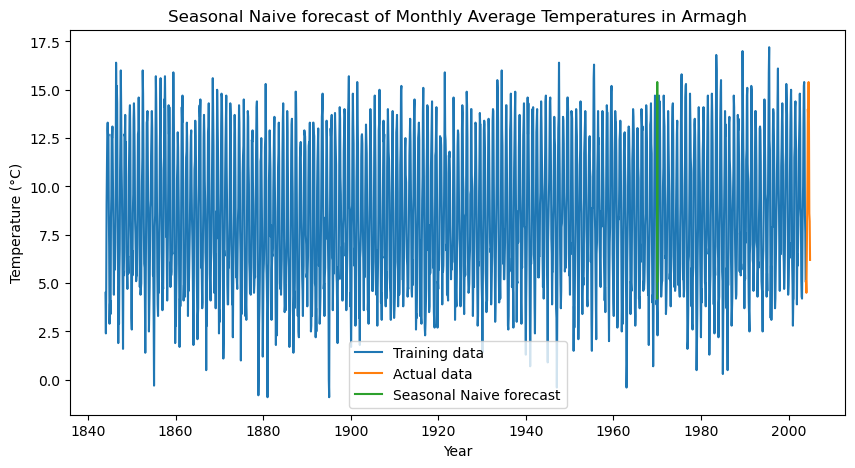

In [19]:
# Create a seasonal naive model
seasonal_naive_model_predictions = []
for i in range(len(test)):
    idx = i % 12
    seasonal_naive_model_predictions.append(train.iloc[-12+idx, 0])

# Calculate the evaluation metrics
mse = mean_squared_error(test, seasonal_naive_model_predictions)
mae = mean_absolute_error(test, seasonal_naive_model_predictions)
r2 = r2_score(test, seasonal_naive_model_predictions)

print("Seasonal Naive Model:")
print(f"Seasonal Naive Model RMSE: {mse ** 0.5:.2f}")
print(f"Seasonal Naive Model MAE: {mae:.2f}")
print(f"Seasonal Naive Model R2 Score: {r2:.2f}")

# Plot the forecast and actual values
plt.figure(figsize=(10,5))
plt.plot(train, label='Training data')
plt.plot(test, label='Actual data')
plt.plot(seasonal_naive_model_predictions, label='Seasonal Naive forecast')
plt.title('Seasonal Naive forecast of Monthly Average Temperatures in Armagh')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

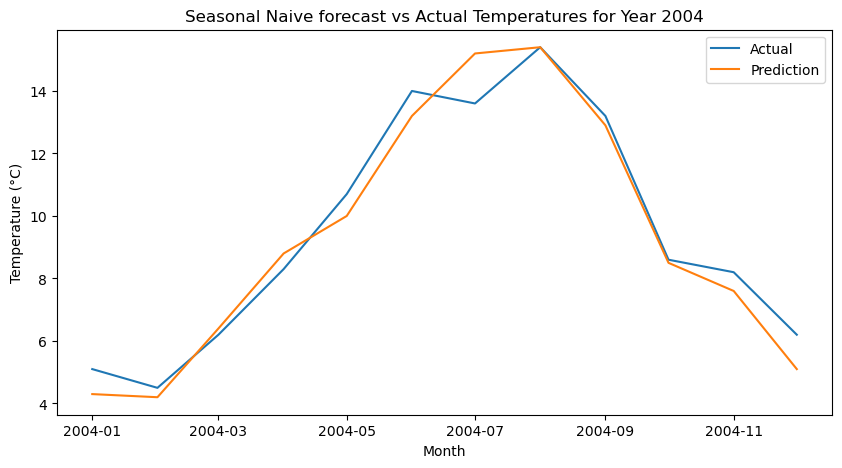

In [20]:
# Plot the actual values and forecast
plt.figure(figsize=(10,5))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, seasonal_naive_model_predictions, label='Prediction')
plt.title('Seasonal Naive forecast vs Actual Temperatures for Year 2004')
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()